# Get Bio-ARGO data

this is the code that created the first version of my bio argo dataset

## Workflow

Here is our basic workflow.

1. Use `argopy` to fetch data for Bio-Argo profiles in a given region and time
2. Get only CHLA and PRES (depth)
3. For each profile, save one point, the shallowest reading.
4. Only use points that are near the surface (PRES < 20db)

In [1]:
!pip install argopy

  Using cached argopy-1.3.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached xarray-2025.11.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
Using cached argopy-1.3.1-py3-none-any.whl (892 kB)
Using cached fsspec-2025.10.0-py3-none-any.whl (200 kB)
Using cached xarray-2025.11.0-py3-none-any.whl (1.4 MB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: xarray━━━━━━━━━━━━━━━━━━ 0/3 [fsspec]
    Found existing installation: xarray 2025.3.1 0/3 [fsspec]
    Uninstalling xarray-2025.3.1:━━━━━━━━━━━ 0/3 [fsspec]
      Successfully uninstalled xarray-2025.3.10m 0/3 [fsspec]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [argopy]2m2/3 [argopy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [2]:
import xarray as xr

In [3]:
# show how to get some basic data
from argopy import DataFetcher as ArgoDataFetcher

# North Atlantic box:
# lon: -70 to 10
# lat:  20 to 60
# pres: 0 to 300 dbar
# time: 2024 one month
region = [-70, -40, 20, 60, 0, 1000, "2024-03-01", "2024-04-01"]

# params: BBP700,CHLA,DOXY,NITRATE,PH_IN_SITU_TOTAL,PRES,PSAL,TEMP
fetcher_na = ArgoDataFetcher(
    ds="bgc",
    src="erddap",
    params=["CHLA", "PRES"]
)

ds_na = (
    fetcher_na
    .region(region)
    .to_xarray()
)

<xarray.Dataset> Size: 1MB
Dimensions:          (N_POINTS: 9267)
Coordinates:
  * N_POINTS         (N_POINTS) int64 74kB 0 1 2 3 4 ... 9263 9264 9265 9266
    LATITUDE         (N_POINTS) float64 74kB 27.53 35.76 23.02 ... 39.93 26.89
    LONGITUDE        (N_POINTS) float64 74kB -50.32 -56.92 ... -68.26 -50.2
    TIME             (N_POINTS) datetime64[ns] 74kB 2024-03-01T05:16:51.00099...
Data variables: (12/21)
    CHLA             (N_POINTS) float32 37kB 0.0036 0.0036 ... 0.005341 0.0
    CHLA_DATA_MODE   (N_POINTS) <U1 37kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    CHLA_ERROR       (N_POINTS) float32 37kB 0.0072 0.0072 0.02847 ... nan 0.0
    CHLA_QC          (N_POINTS) int64 74kB 1 1 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1 1
    CYCLE_NUMBER     (N_POINTS) int64 74kB 107 103 78 78 78 ... 21 21 21 21 110
    DIRECTION        (N_POINTS) <U1 37kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    ...               ...
    PSAL_QC          (N_POINTS) int64 74kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1


/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


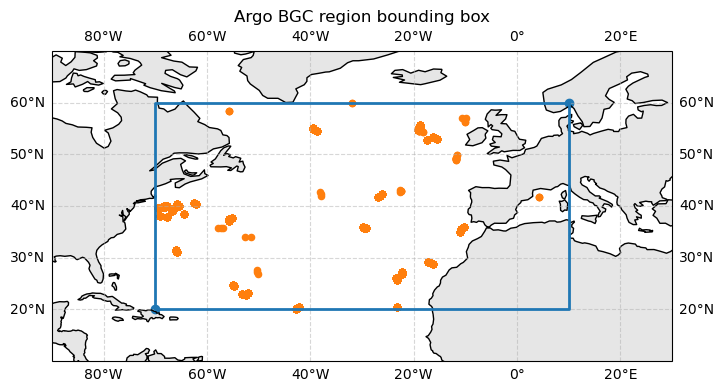

In [21]:
# this shows how to plot the data all
lon_min, lon_max, lat_min, lat_max = region[:4]
ds = ds_na

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Corners of the box (closed loop)
lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
lats = [lat_min, lat_min, lat_max, lat_max, lat_min]

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=proj)

# Show a bit more context than just the box
ax.set_extent([lon_min - 20, lon_max + 20, lat_min - 10, lat_max + 10], crs=proj)

# Add coastlines and land
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# Plot the bounding box
ax.plot(lons, lats, transform=proj, linewidth=2)
ax.scatter([lon_min, lon_max], [lat_min, lat_max], transform=proj)

# Add the Argo points from ds
ax.scatter(
    ds["LONGITUDE"].values,
    ds["LATITUDE"].values,
    s=20,
    marker="o",
    transform=proj,
)

ax.set_title("Argo BGC region bounding box")

plt.show()



In [12]:
# this shows how to get the surface data
import numpy as np
import pandas as pd

ds = ds_na

cols = ["CHLA", "PRES", "TIME", "LATITUDE", "LONGITUDE",
        "PLATFORM_NUMBER", "CYCLE_NUMBER"]
df_all = ds[cols].to_dataframe().reset_index(drop=True)

# For each profile (float+cycle), find the shallowest measurement:
df_surf = (
    df_all
    .sort_values("PRES")  # shallowest first
    .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
    .first()              # take the row with min PRES in each group
)

# Filter out neg vals and non surface values
df_surf = df_surf[df_surf["CHLA_0m_approx"] > 0]
df_surf = df_surf[df_surf["PRES"] < 20]
df_surf = df_surf.reset_index(drop=True)

# Add log10 target for BRT
df_surf["log10_CHLA_0m_approx"] = np.log10(df_surf["CHLA_0m_approx"])

print(df_surf.head())
print("Number of profiles (shallowest samples):", len(df_surf))


   PLATFORM_NUMBER  CYCLE_NUMBER  CHLA_0m_approx  PRES  \
0          1902383            78        0.014237  2.09   
1          1902383            79        0.011072  2.28   
2          1902383            80        0.010280  2.35   
3          1902384            79        0.025275  2.26   
4          1902384            80        0.019503  0.84   

                           TIME  LATITUDE  LONGITUDE  log10_CHLA_0m_approx  
0 2024-03-02 16:13:24.002000128   23.0209   -53.2220             -1.846566  
1 2024-03-12 15:19:00.002000128   22.7279   -52.3932             -1.955794  
2 2024-03-22 15:28:33.002000128   23.2649   -52.0005             -1.988007  
3 2024-03-08 20:58:18.002000128   20.0154   -42.7101             -1.597309  
4 2024-03-18 20:31:41.002000128   20.3018   -42.5525             -1.709899  
Number of profiles (shallowest samples): 33


In [2]:
# This is the code that got the files
# Month starts for 2024
month_starts = pd.date_range("2024-03-01", "2024-09-01", freq="MS")

for i, start in enumerate(month_starts[:-1]):
    end = month_starts[i + 1]  # next month start
    t0 = start.strftime("%Y-%m-%d")
    t1 = end.strftime("%Y-%m-%d")
    
    region = [
        LON_MIN, LON_MAX,
        LAT_MIN, LAT_MAX,
        PRES_MIN, PRES_MAX,
        t0, t1
    ]
    
    print(f"=== Fetching {t0} → {t1} ===")
    try:
        ds = (
            fetcher_na
            .region(region)
            .to_xarray()
        )
    except Exception as e:
        print(f"  ERDDAP error for {t0}–{t1}: {e}")
        continue
    
    # Skip empty months
    n_points = ds.sizes.get("N_POINTS", 0)
    if n_points == 0:
        print("  No data (N_POINTS = 0), skipping.")
        continue
    
    # Save to NetCDF
    fname = out_dir / f"bgc_nae_{start:%Y%m}.nc"
    ds.to_netcdf(fname)
    print(f"  Saved {n_points} points to {fname}")


NameError: name 'pd' is not defined

In [ ]:
# load in all the files and make one dataset
import xarray as xr

files = sorted(out_dir.glob("bgc_na_*.nc"))
ds_all = xr.concat([xr.open_dataset(f) for f in files], dim="N_POINTS")

print(ds_all)

In [5]:
# process files one by one and get the surface data
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr


def make_surface_chla_from_raw_monthly(
    path,
    pattern="bgc_na*_*.nc",
    max_surface_depth=20,
    use_qc=True,
    out_file="na_surface_chla.parquet",
):
    """
    Ingest monthly BGC Argo NetCDFs (as saved from ERDDAP),
    extract one near-surface CHLA value per profile, and
    return a combined DataFrame and save it to disk.

    Parameters
    ----------
    path : str or Path
        Directory containing monthly NetCDF files (e.g., "bgc_na_raw_monthly").
    pattern : str
        Glob pattern to match files in `path` (default "bgc_na_*.nc").
    max_surface_depth : float
        Maximum "shallowest PRES" (dbar) allowed for a profile to be
        treated as having surface CHLA (default 20 dbar).
    use_qc : bool
        If True and CHLA_QC is present, keep only QC 1 and 2.
    out_file : str or Path
        Output file (Parquet). If None, no file is written.

    Returns
    -------
    df_surface_all : pandas.DataFrame
        Combined table of surface CHLA per profile across all files.
        Columns include:
          PLATFORM_NUMBER, CYCLE_NUMBER, PRES (shallowest),
          CHLA_surface, log10_CHLA_surface, LATITUDE, LONGITUDE, TIME,
          min_pres, lat, lon, time (summary per profile).
    """
    path = Path(path)
    files = sorted(path.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files matching {pattern} found in {path}")

    print(f"Found {len(files)} files in {path} matching {pattern}")

    all_dfs = []

    for f in files:
        print(f"--- Processing {f.name} ---")
        ds = xr.open_dataset(f)

        n_points = ds.sizes.get("N_POINTS", 0)
        if n_points == 0:
            print("  N_POINTS = 0, skipping.")
            ds.close()
            continue

        # Required variables
        required_vars = [
            "PLATFORM_NUMBER",
            "CYCLE_NUMBER",
            "PRES",
            "CHLA",
            "LATITUDE",
            "LONGITUDE",
            "TIME",
        ]
        missing = [v for v in required_vars if v not in ds.variables]
        if missing:
            print(f"  Missing variables {missing} in {f.name}, skipping.")
            ds.close()
            continue

        # Build DataFrame of all points in this file
        df_all = ds[required_vars].to_dataframe().reset_index(drop=True)

        # Optional QC filter
        if use_qc and "CHLA_QC" in ds:
            df_qc = ds[["CHLA_QC"]].to_dataframe().reset_index(drop=True)
            df_all["CHLA_QC"] = df_qc["CHLA_QC"]
            # Keep only QC 1 and 2 (good/probably good)
            mask_qc = df_all["CHLA_QC"].isin([1, 2, "1", "2"])
            before_qc = len(df_all)
            df_all = df_all[mask_qc].copy()
            print(f"  QC filter: kept {len(df_all)} / {before_qc} points")
        else:
            print("  QC filter: not applied (CHLA_QC missing or use_qc=False)")

        if df_all.empty:
            print("  No points left after QC, skipping.")
            ds.close()
            continue

        # Shallowest pressure per profile
        df_shallow = (
            df_all.groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"])
                  .agg(
                      min_pres=("PRES", "min"),
                      lat=("LATITUDE", "mean"),
                      lon=("LONGITUDE", "mean"),
                      time=("TIME", "mean"),
                  )
        )

        # Keep only profiles with shallowest level <= max_surface_depth
        df_good = df_shallow[df_shallow["min_pres"] <= max_surface_depth]
        print(
            "  Profiles with min_pres <=", max_surface_depth,
            "dbar:", len(df_good)
        )
        if df_good.empty:
            print("  No profiles with shallow near-surface CHLA, skipping file.")
            ds.close()
            continue

        # Join back to get the shallowest CHLA for those profiles
        good_ids = df_good.index  # (PLATFORM_NUMBER, CYCLE_NUMBER) pairs

        df_all_idx = df_all.set_index(["PLATFORM_NUMBER", "CYCLE_NUMBER"])
        df_surface = (
            df_all_idx
            .loc[good_ids]
            .sort_values("PRES")              # shallowest first
            .groupby(level=[0, 1])
            .first()
        )

        # Rename CHLA & compute log10
        df_surface = df_surface.rename(columns={"CHLA": "CHLA_surface"})
        df_surface = df_surface[df_surface["CHLA_surface"] > 0].copy()   
        df_surface["log10_CHLA_surface"] = np.log10(df_surface["CHLA_surface"])

        # Attach shallow summary (min_pres, lat, lon, time)
        df_surface = df_surface.join(df_good[["min_pres", "lat", "lon", "time"]])

        # Keep track of source file/month (optional but handy)
        df_surface["source_file"] = f.name

        all_dfs.append(df_surface.reset_index())

        ds.close()

    if not all_dfs:
        print("No surface profiles found in any file.")
        return pd.DataFrame()

    # Concatenate all months
    df_surface_all = pd.concat(all_dfs, ignore_index=True)
    print("Total surface profiles across all files:", len(df_surface_all))

    # Save to disk
    if out_file is not None:
        out_file = Path(out_file)
        if out_file.suffix == "":
            out_file = out_file.with_suffix(".parquet")

        if out_file.suffix == ".parquet":
            df_surface_all.to_parquet(out_file)
        elif out_file.suffix == ".csv":
            df_surface_all.to_csv(out_file, index=False)
        else:
            raise ValueError(f"Unsupported output format: {out_file.suffix}")

        print(f"Saved combined surface CHLA table to {out_file}")

    return df_surface_all


In [7]:
# Make the dataframe from all the files
raw_dir = "data"

df_surface_na = make_surface_chla_from_raw_monthly(
    raw_dir,
    pattern="bgc_na*_*.nc",
    max_surface_depth=50,           # treat profiles with min_pres <= 20 dbar as "surface"
    use_qc=True,
    out_file="na_surface_chla.parquet"  # or "na_surface_chla.csv"
)

df_surface_na.head()
len(df_surface_na)

Found 40 files in data matching bgc_na*_*.nc
--- Processing bgc_na_202403.nc ---
  QC filter: kept 9066 / 9267 points
  Profiles with min_pres <= 50 dbar: 28
--- Processing bgc_na_202404.nc ---
  QC filter: kept 9278 / 9468 points
  Profiles with min_pres <= 50 dbar: 32
--- Processing bgc_na_202405.nc ---
  QC filter: kept 9814 / 9873 points
  Profiles with min_pres <= 50 dbar: 35
--- Processing bgc_na_202406.nc ---
  QC filter: kept 9972 / 10103 points
  Profiles with min_pres <= 50 dbar: 40
--- Processing bgc_na_202407.nc ---
  QC filter: kept 12971 / 13135 points
  Profiles with min_pres <= 50 dbar: 48
--- Processing bgc_na_202408.nc ---
  QC filter: kept 12142 / 12285 points
  Profiles with min_pres <= 50 dbar: 56
--- Processing bgc_na_202409.nc ---
  QC filter: kept 10945 / 11097 points
  Profiles with min_pres <= 50 dbar: 47
--- Processing bgc_na_202410.nc ---
  QC filter: kept 11369 / 11545 points
  Profiles with min_pres <= 50 dbar: 40
--- Processing bgc_na_202411.nc ---
  QC f

1470

In [9]:
df_surface_na

,PLATFORM_NUMBER,CYCLE_NUMBER,PRES,CHLA_surface,LATITUDE,LONGITUDE,TIME,CHLA_QC,log10_CHLA_surface,min_pres,lat,lon,time,source_file
0,1902383,78,19.889999,0.017404,23.0209,-53.2220,2024-03-02 16:13:24.002000128,1,-1.759363,19.889999,23.0209,-53.2220,2024-03-02 16:13:24.002000128,bgc_na_202403.nc
1,1902383,79,7.980000,0.011863,22.7279,-52.3932,2024-03-12 15:19:00.002000128,1,-1.925805,7.980000,22.7279,-52.3932,2024-03-12 15:19:00.002000128,bgc_na_202403.nc
2,1902383,80,11.850000,0.066477,23.2649,-52.0005,2024-03-22 15:28:33.002000128,1,-1.177332,11.850000,23.2649,-52.0005,2024-03-22 15:28:33.002000128,bgc_na_202403.nc
3,1902384,79,2.260000,0.025275,20.0154,-42.7101,2024-03-08 20:58:18.002000128,1,-1.597309,2.260000,20.0154,-42.7101,2024-03-08 20:58:18.002000128,bgc_na_202403.nc
4,1902384,80,2.140000,0.014453,20.3018,-42.5525,2024-03-18 20:31:41.002000128,1,-1.840057,2.140000,20.3018,-42.5525,2024-03-18 20:31:41.002000128,bgc_na_202403.nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,6999997,8,2.200000,0.060032,36.5940,-50.1173,2025-10-14 20:43:17.002000128,2,-1.221617,2.200000,36.5940,-50.1173,2025-10-14 20:43:17.002000128,bgc_na_202510.nc
790,6999997,9,2.100000,0.084688,37.1402,-49.4328,2025-10-24 21:55:14.002000128,2,-1.072178,2.100000,37.1402,-49.4328,2025-10-24 21:55:14.002000128,bgc_na_202510.nc
791,7902226,28,11.950000,0.016028,23.9980,-50.4680,2025-10-08 15:25:55.002000128,1,-1.795121,11.950000,23.9980,-50.4680,2025-10-08 15:25:55.002000128,bgc_na_202510.nc
792,7902226,29,14.030000,0.014794,23.6563,-50.1012,2025-10-18 16:56:25.002000128,1,-1.829914,14.030000,23.6563,-50.1012,2025-10-18 16:56:25.002000128,bgc_na_202510.nc
